In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:14pt;}
div.text_cell_render.rendered_html{font-size:14pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:30px;}
div.output {font-size:14pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:14pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:14pt;padding:5px;}
table.dataframe{font-size:14px;}
</style>
"""))

# red wine 품질 등급 예측

```
* 1. 데이터셋 확보 & 전처리
   독립변수와 타겟변수 분리 -> 독립변수 스케일 조정(StandardScaler),  
    -> 타겟변수 원핫인코딩(pd.get_dummies) -> 훈련셋과 테스트셋 분리(train_test_split)
* 2. 모델 구성(입력11, 출력?)
* 3. 모델 학습과정 설정(다중분류로 설정)
* 4. 모델 학습(callbacks 이용)
* 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표
* 6. 모델 저장/사용
```

In [25]:
import numpy as np
import pandas as pd   # read_csv, get_dummies, crosstab  ## 파일 읽어오기위해
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model  # 모델관련
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics  # compile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt   # 학습과정 시각화

## 1. 데이터셋 확보 & 전처리
- 독립변수와 타겟변수 분리 
    -> 독립변수 스케일 조정(StandardScaler),  
    -> 타겟변수 원핫인코딩(pd.get_dummies) 
    -> 훈련셋과 테스트셋 분리(train_test_split)

In [26]:
# 데이터 읽어오기
# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)  # 결측치없다는 전제하에
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)
redwine = pd.read_csv('./data/winequality-red.csv', sep=';')
# 고정 산도(fixed acidity)
# 휘발성 산도(volatile acidity)
# 구연산(citric acid)
# 잔여 당분(residual sugar)
# 염화물(chlorides)
# 유리 아황산염(free sulfur dioxide)
# 총 아황산염(total sulfur dioxide)
# 밀도(density)
# pH
# 황산염(sulphates)
# 알코올(alcohol)
# -- 타겟 변수 : quality
redwine.info()  ## 결측치 확인(없음)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [27]:
# 타겟변수의 균형 확인
redwine['quality'].value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [28]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
# 독립변수, 타겟변수 분리
X_redwine = redwine.iloc[:, :-1].values  # to_numpy와 유사. numpy배열로(sklearn 라이브러리 사용을 위해)
y_redwine = redwine.iloc[:, -1]  # 시리즈  3,4,5,6,7,8
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [30]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()   # 또는 MinmaxScaler()
scaler.fit(X_redwine)
scaled_X_redwine = scaler.transform(X_redwine)

# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy배열로 형변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()
# Y_redwine

In [31]:
scaled_X_redwine[:1]
Y_redwine
print('원데이터:\t원핫인코딩')
# 원핫인코딩한 0번째 인덱스가 3등급(get_dummies()사용해서)
np.column_stack([y_redwine[3:5], Y_redwine[3:5]])

원데이터:	원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [ ]:
# 그림

In [32]:
# 독립변수:scaled_X_redwine  & 타겟변수:Y_redwine
scaled_X_redwine.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [33]:
# 훈련셋과 테스트셋 분리(층화추출-모든 등급의 비율이 같게) = 7:3
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine,
                                                    Y_redwine,
                                                    # test_size=0.3,
                                                    train_size=0.7,
                                                    stratify=Y_redwine, # 층화추출을 위해
                                                    random_state=12)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1119, 11), (480, 11), (1119, 6), (480, 6))

In [34]:
# 타겟변수의 균형 확인
# redwine['quality'].value_counts(normalize=True)  # value_counts는 시리즈나 데이터프레임에만 사용가능
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),   # np.c_ : np.colum_stack과 같다
pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),           # Y_train등이 원핫인코딩된 데이터라 시리즈로 만들려면 argmax() 적용해야함
pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

## 2. 모델 구성(입력11, 출력6)

In [38]:
model = Sequential()
model.add(Input(11))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30,'relu'))
model.add(Dense(units=6,  activation='softmax'))
model.summary()  # 11*50+50=600, 50*50+50=2550, 50*30+30=1530, 30*6+6=186  ## 입력*출력+출력 ==> wait와 bias의 갯수

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                600       
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 30)                1530      
                                                                 
 dense_11 (Dense)            (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


## 3. 모델 학습과정 설정(다중분류에 맞는 설정)

## 4. 학습시키기(callbacks 이용)

In [39]:
%%time
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
class CustomHistory(Callback):  # on_epoch_end() 함수가 epoch수행후 자동호출됨
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                 .format(self.epoch,
                         logs.get('loss'),
                         logs.get('accuracy'),
                         logs.get('val_loss'),
                         logs.get('val_accuracy')
                )
         )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder):  # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
# wine-080-loss1.5424-val0.8412.h5    # 저장될 파일이름의 형식
file = model_save_folder \
        + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
    
# 콜백 객체 생성
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy',  # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,     # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0)   # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)

# 학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                 validation_split=0.2, # 학습셋의 20%는 검증셋으로
                 verbose=0,   # 로그출력 막음(콜백함수에서 출력)
                 callbacks=[earlyStopping,
                           customHistory,
                           checkpoint])

1번째 loss:1.8539, acc:0.0827, val_loss:1.7226, val_acc:0.2679
5번째 loss:1.3655, acc:0.5263, val_loss:1.3676, val_acc:0.4866
10번째 loss:1.0563, acc:0.5832, val_loss:1.1448, val_acc:0.5223
15번째 loss:0.9756, acc:0.6078, val_loss:1.0896, val_acc:0.5357
20번째 loss:0.9411, acc:0.6168, val_loss:1.0631, val_acc:0.5402
25번째 loss:0.9123, acc:0.6190, val_loss:1.0444, val_acc:0.5402
30번째 loss:0.8935, acc:0.6335, val_loss:1.0377, val_acc:0.5491
35번째 loss:0.8803, acc:0.6346, val_loss:1.0372, val_acc:0.5625
40번째 loss:0.8650, acc:0.6291, val_loss:1.0310, val_acc:0.5402
45번째 loss:0.8490, acc:0.6425, val_loss:1.0236, val_acc:0.5536
50번째 loss:0.8236, acc:0.6659, val_loss:1.0197, val_acc:0.5446
55번째 loss:0.8112, acc:0.6570, val_loss:1.0248, val_acc:0.5625
60번째 loss:0.8049, acc:0.6547, val_loss:1.0137, val_acc:0.5625
65번째 loss:0.7796, acc:0.6659, val_loss:1.0108, val_acc:0.5714
70번째 loss:0.7743, acc:0.6760, val_loss:1.0211, val_acc:0.5714
75번째 loss:0.7549, acc:0.6704, val_loss:1.0149, val_acc:0.5759
80번째 loss:

## 5. 모델 평가
- 학습과정 시각화, 평가(테스트셋), 교차표(혼동행렬)

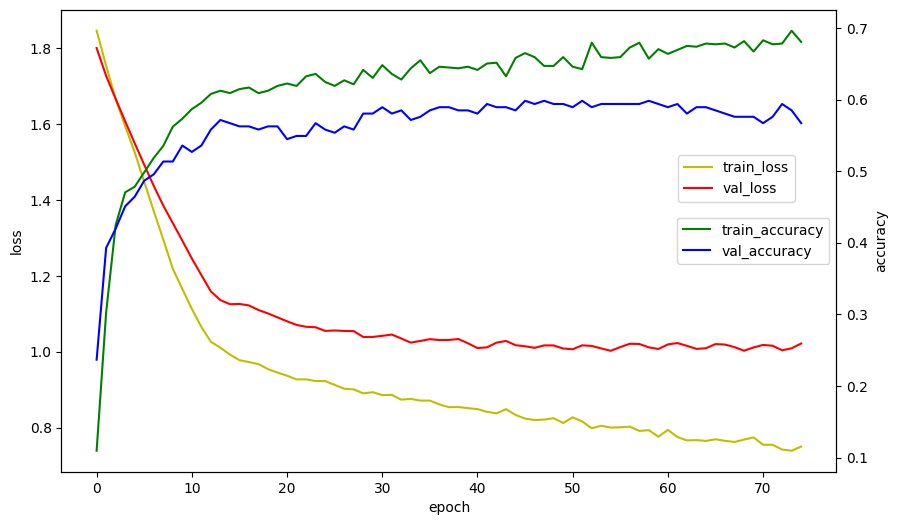

In [37]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'],'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'],'r', label='val_loss')
acc_ax = loss_ax.twinx()  # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [44]:
# 모델 평가
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.9548, accuracy:0.6396


In [41]:
X_test.shape

(480, 11)

In [46]:
model1 = load_model('./model/wine-046-loss1.0143-acc0.5982.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:0.9685, accuracy:0.6187


In [47]:
model.save('model/wine.h5')

In [54]:
# 교차표 (실제값과 예측값은 1차원 데이터로 만들어야 crosstab가능)
real = Y_test.argmax(axis=1)+3  # 실제값:to_categorycal하지 않고 get_dummies했기 때문에 
                                # 값이 0~로 변형되었기 때문에 +3해줘야 원래 데이터로 복원됨
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1)+3  # 예측값  
# pred = np.argmax(model.predict(X_test), axis=1)

pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 1ms/step


predict,5,6,7
real,,,
3,3,0,0
4,9,6,1
5,149,51,4
6,48,133,11
7,4,31,25
8,0,2,3


## 6. 모델 사용하기

In [57]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [62]:
input_data = [7.4, 0.7, 0., 1.9, 0.076,11., 34., 0.9978, 3.51, 0.56, 9.4]
scaled_data = scaler.transform([input_data])
model.predict(scaled_data).argmax(axis=1)+3

1/1 [==============================] - 0s 52ms/step


array([5], dtype=int64)